In [54]:
EMULATORS_PATH = "/Users/gabe/projects/emulators/src"
RECOMBINATION_PATH = "/Users/gabe/projects/recombination/src"
PLANCK_LITE_PATH = "/Users/gabe/projects/planck/planck-lite-py"

import sys
import os
import numpy as np
from scipy.interpolate import CubicSpline
import classy as Class


import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr
from mpl_toolkits.axes_grid1 import make_axes_locatable

if EMULATORS_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/emulators/src")
if RECOMBINATION_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/recombination/src")
if PLANCK_LITE_PATH not in sys.path:
    sys.path.insert(0, PLANCK_LITE_PATH)
from TrainedEmulator import *
from ChainTools import *
from RecTools import CosmoCalculator
from planck_lite_py import PlanckLitePy

from getdist import plots, MCSamples, loadMCSamples

sys.path.insert(0, "/Users/gabe/projects/wave/src")
import constants as con

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

default_settings = plots.GetDistPlotSettings()
default_settings.axes_labelsize = 12
default_settings.fig_width_inch = 6
default_settings.linewidth = 2
default_settings.title_limit = 0
default_settings.legend_fontsize = 12

######################################################
#  Loading Chains
######################################################

#chains_to_load = ["modrec_prec", "modrec_prec_lensing", "lcdm_prec_lensing", "modrec_prec_lensing_bao", "lcdm_prec_lensing_bao"]
chains_to_load = ["lcdm_prec_lensing", "modrec_new_lensing", "modrec_new_lensing_bao", "modrec_new_lensing_bao_shoes"]

chains = {}

burnin_dict = {"modrec_new": 0.5,
               "modrec_new_lensing": 0.5,
               "modrec_new_lensing_bao": 0.6,
               "modrec_new_lensing_underdisperse": 0.05,
               "modrec_new_lensing_bao_shoes": 0.5,
               "lcdm_prec_lensing": 0.05,}

chain_dirname = "/Users/gabe/projects/recombination/data/chains/"

for chain in chains_to_load:
    dirname = os.path.join(chain_dirname, "{}/chains".format(chain))
    s = loadMCSamples(os.path.join(dirname, chain), settings={"ignore_rows": burnin_dict[chain], "fine_bins": 2048})
    chains[chain] = s


s_planck = loadMCSamples(os.path.join(chain_dirname, "planck_baseline/base_plikHM_TTTEEE_lowl_lowE_lensing"))

planck_renames = {'omegabh2': 'omega_b',
                  'omegach2': 'omega_cdm', 
                  'tau': 'tau_reio', 
                  'ns': 'n_s',
                  "kd": "k_D",
                  "thetastar": "theta_star_100",
                  "rstar": "rs_star",}
s_planck.updateRenames(planck_renames)
chains["planck_baseline"] = s_planck
planck_bestfit = chains["planck_baseline"].getParamBestFitDict()

######################################################
#  Loading Emulator
######################################################

emulator_dir = "/Users/gabe/projects/emulators/models"
emulator_name = "modrec_new_18"

em = TrainedEmulator(os.path.join(emulator_dir, emulator_name))

## Standard ruler functions

In [2]:
ln10e10As = 3.044
planck_baseline_params = {
    "omega_b": 0.02237,
    "omega_cdm": 0.1200,
    "n_s": 0.9649,
    "tau_reio": 0.0544,
    "ln10^{10}A_s": ln10e10As,
    "H0": 67.36}

cosmo = CosmoCalculator(planck_baseline_params)

In [3]:
settings = {}
settings.update(planck_baseline_params)
settings.update({'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   "accurate_lensing": 1,
                   'xe_pert_type': 'none',
                   'modes': "s",
                   'N_ur': 2.0308,
                    'N_ncdm': 1,
                  'm_ncdm': 0.06,
                  'T_ncdm': 0.71611,
                  })

M = Class.Class()
M.set(settings)
M.compute()

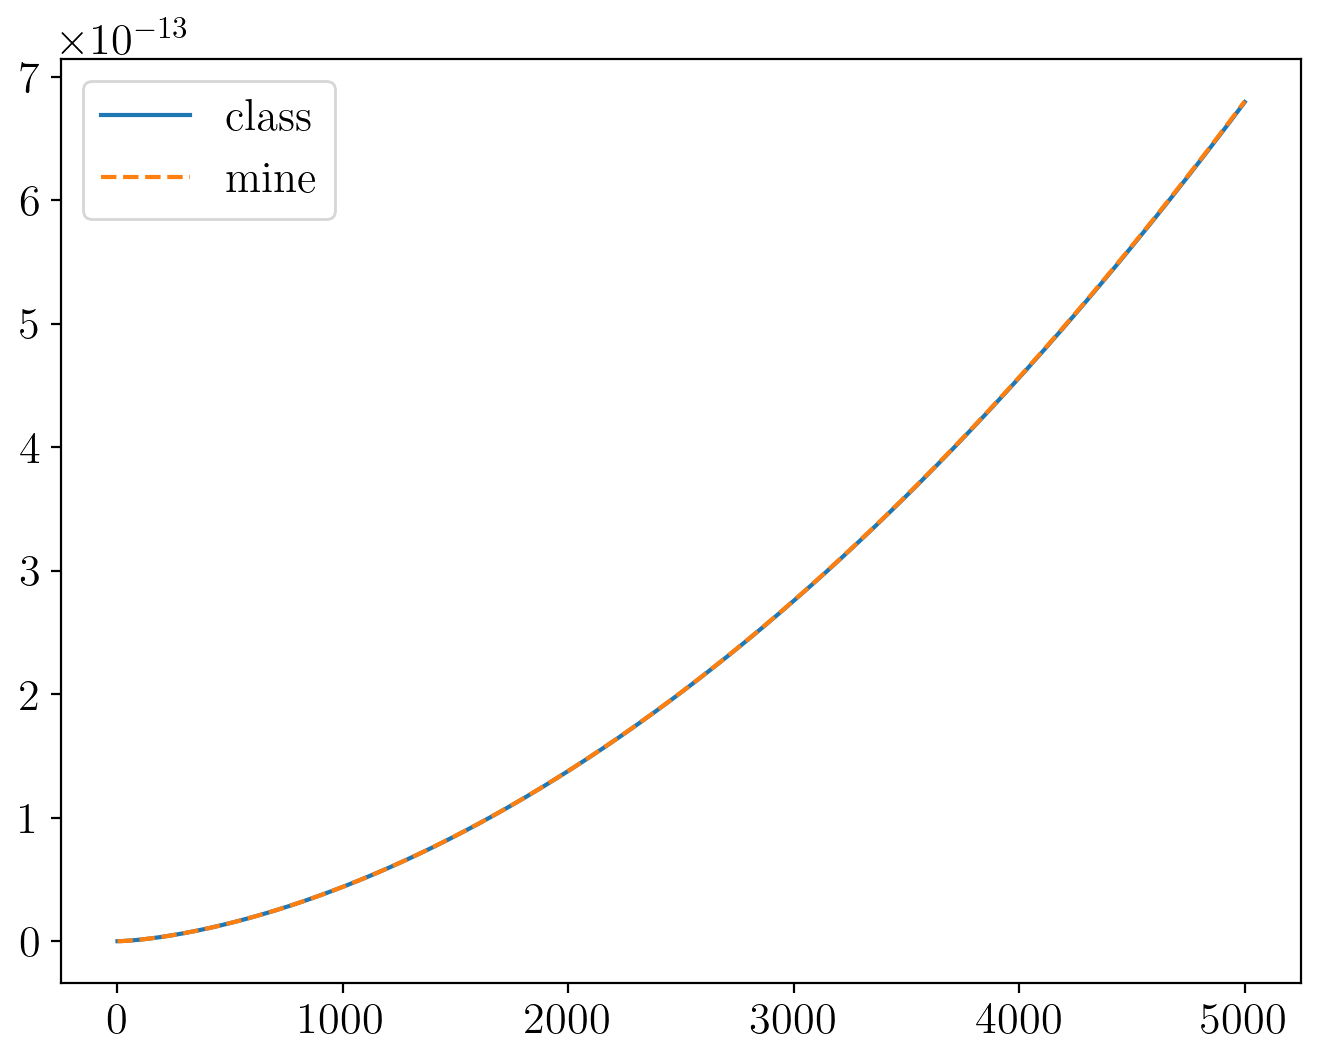

In [4]:
zgrid = np.linspace(0, 5000, 1000)

cMpc = 9.716e-15

class_hubble = cMpc*np.array([M.Hubble(z) for z in zgrid])
my_hubble = np.array([cosmo.Hubble(z) for z in zgrid])

fig,ax = plt.subplots()

ax.plot(zgrid, class_hubble, label="class")
ax.plot(zgrid, my_hubble, linestyle="dashed", label="mine")
ax.legend()
plt.show()

In [5]:
import scipy.integrate

thermo = M.get_thermodynamics()
xe_func = CubicSpline(thermo["z"], thermo["x_e"], extrapolate=True)

def R(z, cosmo):
    return ((3*cosmo.omega_b)/(4*cosmo.omega_g))*(1+z)**-1

def cs(z, cosmo):
    return np.sqrt(1/(3*(1+R(z, cosmo))))

# n_e * sigma_t * a
def tau_dot(z, cosmo):
    thom = 6.65246e-25 #cm^2
    m_H = 9.3827e8 # eV
    Yp = 0.24536856816913238
    n_e0 = (cosmo.rho_c0*cosmo.Omega_b/m_H)*(1-Yp) # 1/cm^3, factor of Yp is to convert from rho_b to rho_H. rho_c*Omega_b/m_H is NOT n_H. 
    cm_in_Mpc = 3.086e24 
    return xe_func(z)*(thom*n_e0*cm_in_Mpc)*(1+z)**2

#returns k_d
def k_d(z, cosmo):
    integrand = lambda zp: ((cosmo.Hubble(zp)/cMpc)*tau_dot(zp,cosmo)*(1+R(zp, cosmo)))**(-1) * (R(zp, cosmo)**2/(1+R(zp, cosmo)) + 16./15)
    integral = scipy.integrate.quad(integrand, z, np.inf)[0]
    return 1/np.sqrt((1/6)*integral)

def k_landau(z, cosmo):
    return 1/(cs(z, cosmo)*15.5/np.sqrt(2))

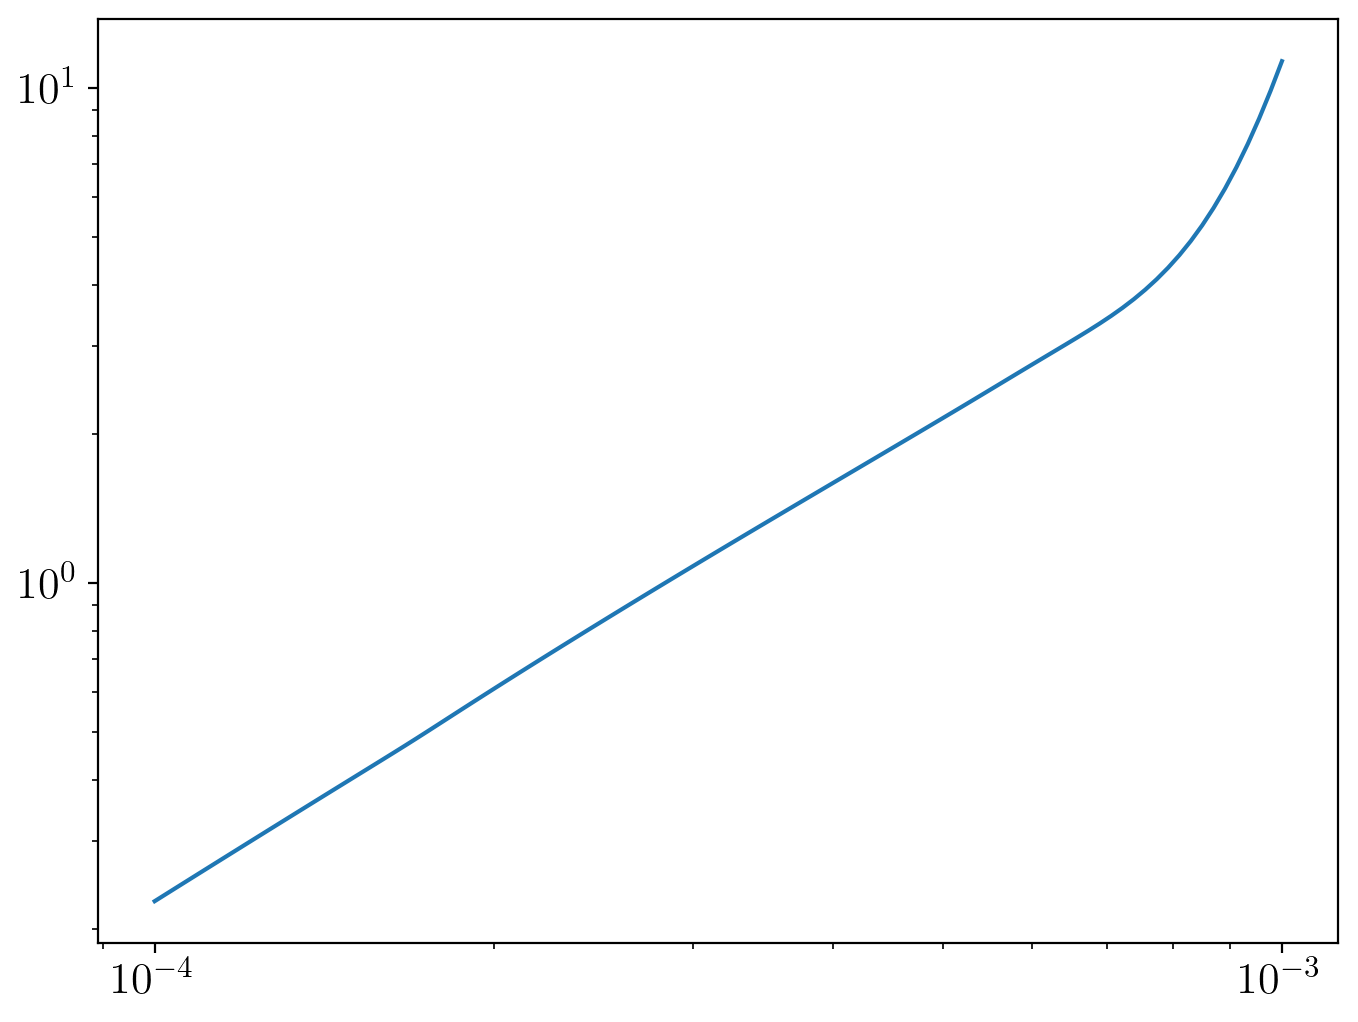

In [6]:
a = np.logspace(-4, -3, 100)

zgrid = 1/a -1 

damping = np.array([1/k_d(z, cosmo) for z in zgrid])

fig,ax = plt.subplots()

ax.plot(a, damping)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()


In [7]:
z = 1085
k_D = 1/np.sqrt(k_d(z, cosmo)**-2 + k_landau(z, cosmo)**-2)
print("1/k_Silk:\t {}".format(1/k_d(z, cosmo)))
print("1/k_Landau:\t {}".format(1/k_landau(z, cosmo)))
print("1/k_D:\t {}".format(1/k_D))

1/k_Silk:	 7.241995649369078
1/k_Landau:	 4.964374665804683
1/k_D:	 8.780177492964707


## Constructing total ionization history 

In [8]:
fid_thermo = M.get_thermodynamics()
z = fid_thermo["z"]
thomson = fid_thermo["kappa\' [Mpc^-1]"]
fid_xe = fid_thermo["x_e"]
my_thomson = tau_dot(z, cosmo)

(500.0, 8000.0)

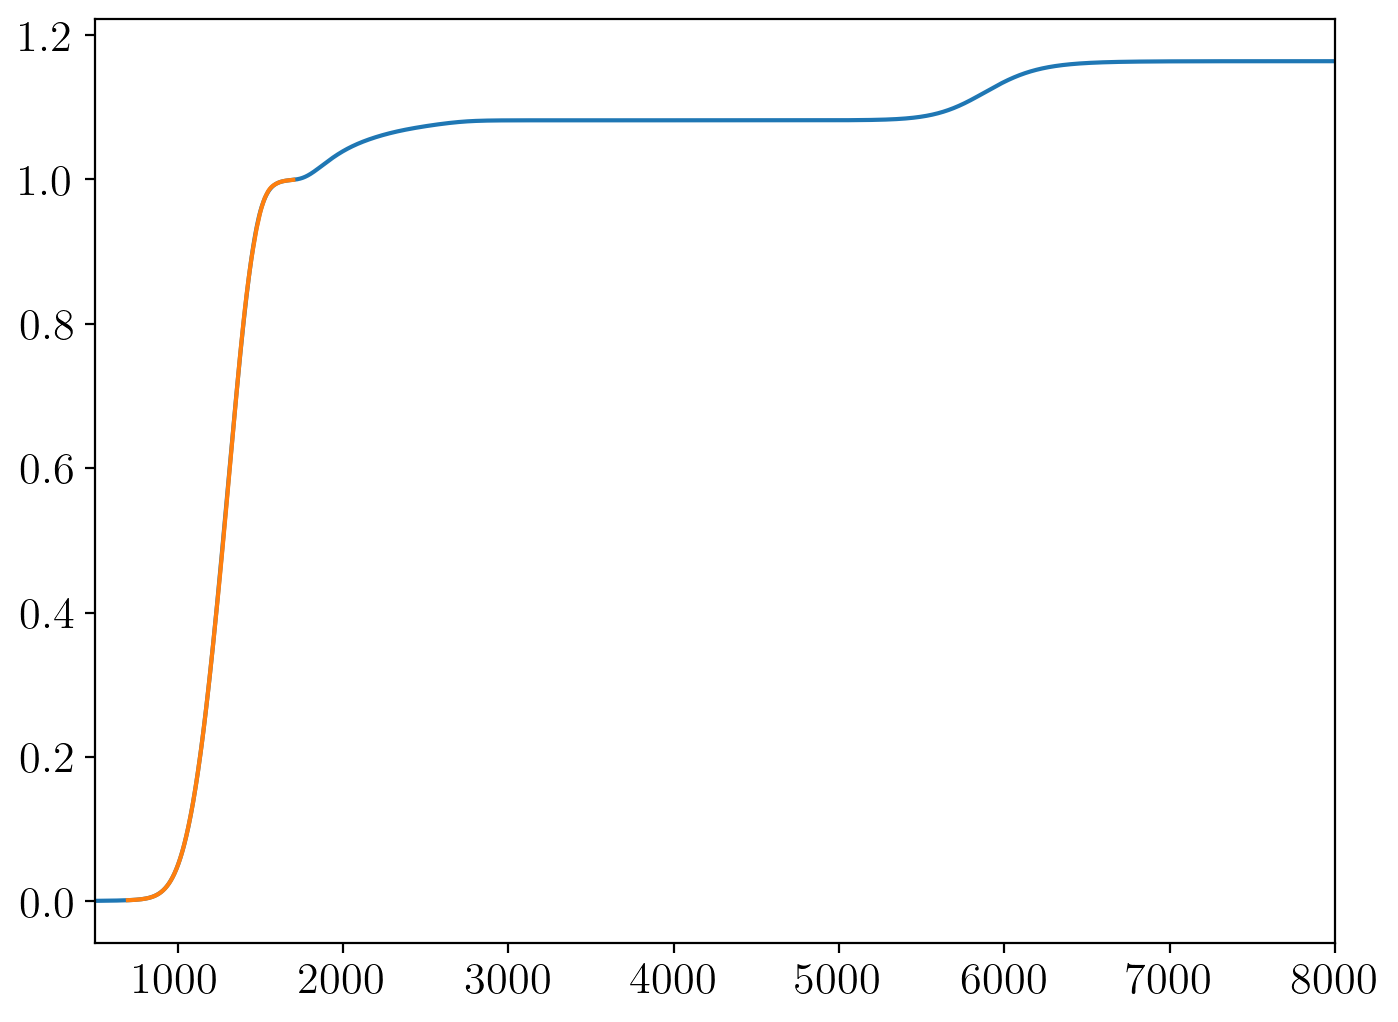

In [9]:
em_input = planck_baseline_params.update({"q_{}".format(i):0.0 for i in np.arange(1,6)})
pred = em.get_predictions_dict(planck_baseline_params)
fig,ax = plt.subplots()

ax.plot(z, fid_xe)
ax.plot(em.output_info["output_z_grids"]["x_e"], pred["x_e"][0])
ax.set_xlim([500, 8000])

In [10]:
n = 10
random_pred, random_models = get_predictions_for_selection(chains["modrec_new_lensing"], em, criteria='random', N=n)

In [11]:
zmin_pert = 800
zmax_pert = 1600
num_free_control_points = 5

def create_cp_string(list_of_control_points):

    list_of_control_points = np.insert(list_of_control_points, 0, 0.0)
    list_of_control_points = np.append(list_of_control_points, 0.0)
    str_ctrl = ["{:.4f}".format(c) for c in list_of_control_points]
    str_ctrl = ",".join(str_ctrl)

    return str_ctrl

pivots = np.linspace(zmin_pert, zmax_pert, 7)
free_pivots = pivots[1:-1]
pivots_str = ",".join(["{:.4f}".format(p) for p in pivots])

precision_settings = {'N_ur': 2.0308,
                'N_ncdm': 1,
                'm_ncdm': 0.06,
                'T_ncdm': 0.71611, #1 species of massive neutrinos
                #'k_max_tau0_over_l_max': 15.00,
                'perturbations_sampling_stepsize': 0.05,
                'xe_pert_type': 'control',
                'xe_pert_num': 7,
                'xe_control_pivots': pivots_str,
                'zmin_pert': zmin_pert,
                'zmax_pert': zmax_pert,
                'start_sources_at_tau_c_over_tau_h': 0.004
                }

M = Class.Class()
M.set(precision_settings)

class_xe_list = []

for i in np.arange(len(random_models["H0"])):
    cosmo_settings = {'output' : 'tCl,pCl',
                    # LambdaCDM parameters
                    'H0':random_models["H0"][i],
                    'omega_b':random_models["omega_b"][i],
                    'omega_cdm':random_models["omega_cdm"][i],
                    'ln10^{10}A_s': random_models["ln10^{10}A_s"][i],
                    'n_s':random_models["n_s"][i],
                    'tau_reio': random_models["tau_reio"][i]
                    }
    cp_list = [random_models["q_{}".format(j)][i] for j in np.arange(1, len(free_pivots)+1)]
    cp_str = create_cp_string(cp_list)
    cosmo_settings.update({"xe_control_points":cp_str})
    M.set(cosmo_settings)
    try:
        M.compute(level=["thermodynamics"])
        thermo = M.get_thermodynamics()
        class_xe_list.append(thermo["x_e"])
        class_z = thermo["z"]
    except Exception as e:
        print(e)

class_xe_list = np.vstack(class_xe_list)

Text(0, 0.5, '$(X_e - X_e^{fid})/X_e^{fid}$ in \\%')

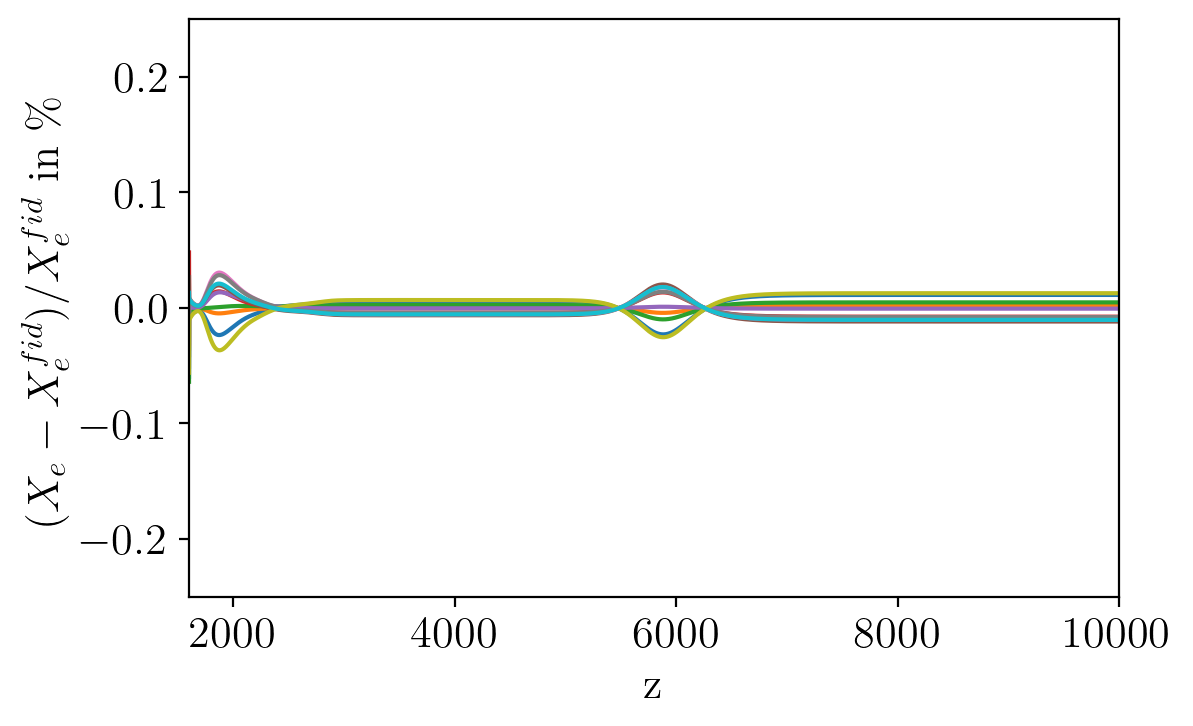

In [12]:
fig,ax = plt.subplots(figsize=(6,3.75))

for x_e in class_xe_list:
    ax.plot(z, (x_e-fid_xe)/fid_xe*100)

ax.set_xlim([1600, 10000])
ax.set_ylim([-.25,.25])
ax.set_xlabel("z")
ax.set_ylabel("$(X_e - X_e^{fid})/X_e^{fid}$ in \%")

In [13]:

fid_z = fid_thermo["z"]
fid_xe = fid_thermo["x_e"]
fid_interp_xe = CubicSpline(fid_z, fid_xe)
def find_index_of(array, values):
    indices_return = []
    for value in values:
        test = np.where(array<value, 1, 0)
        ind = np.argwhere(np.diff(test)!=0)[0][0]
        indices_return.append(ind)
    return indices_return

z_helium_end = 4000 #not truly where helium recombination begins, but rather where the fine grid ends
helium_grid = np.linspace(1800, z_helium_end, 500)
high_z_grid = np.logspace(np.log10(z_helium_end), np.log10(np.max(fid_z)), num=500 )
non_perturb_zgrid = np.hstack([helium_grid, high_z_grid])
non_perturb_xe = fid_interp_xe(non_perturb_zgrid)


def damping(models, em, z_end="z_star"):
    predictions = em.get_predictions_dict(models)
    integrands = []
    total_len = len(models["H0"])
    for i in np.arange(total_len):
        cosmo_model = {k:models[k][i] for k in models.keys()}
        cosmo = CosmoCalculator(cosmo_model)
        if z_end=="z_star":
            z = predictions["z_star"][i]
        else:
            z = z_end
        perturb_zgrid = np.linspace(z, np.max(em.output_info["output_z_grids"]["x_e"]), 500)
        perturb_xe = CubicSpline(em.output_info["output_z_grids"]["x_e"], predictions["x_e"][i])(perturb_zgrid)
        
        total_z = np.hstack([perturb_zgrid, non_perturb_zgrid])
        total_xe = np.hstack([perturb_xe, non_perturb_xe])

        taudot = cosmo.tau_dot(total_z, total_xe, Yp=predictions["YHe"][i])
        Hub = np.array([cosmo.Hubble(zp) for zp in total_z])
        integrand = ((Hub/cMpc)*taudot*(1+cosmo.R(total_z)))**(-1) *  (cosmo.R(total_z)**2/(1+cosmo.R(total_z)) + 16./15)
        integrands.append(integrand)

    integrands = np.vstack(integrands)
    integral = scipy.integrate.simpson(integrands, x=total_z, even="first", axis=1)

    return 1/np.sqrt((1/6)*integral)

In [14]:
input_model = {k:[v] for k,v in planck_baseline_params.items()}
damping(input_model, em)

array([0.1381662])

In [15]:
n=10
random_pred, random_models = get_predictions_for_selection(chains["modrec_new_lensing"], em, criteria='random', N=n)
kds = damping(random_models, em)
print(kds)

[0.13661279 0.13697958 0.13608894 0.13874376 0.1361955  0.13793743]


In [16]:
recompute = False
chains_to_add = ["planck_baseline"]
if recompute:
    for chain_name in chains_to_add:
        print(chain_name)
        total_predictions, total_models = get_predictions_for_selection(chains[chain_name], em, criteria='none')
        k_D = damping(total_models, em)
        chains[chain_name].addDerived(k_D, name="k_D", label="k_D")
        #chains[chain_name].addDerived(total_predictions["100*theta_star"], name="theta_star_100", label="100\\theta_{\star}")
        chains[chain_name].addDerived(total_predictions["rs_star"], name="rs_star", label="r_\star")
        chains[chain_name].addDerived(2*np.pi/k_D, name="r_D", label="r_D")
        chains[chain_name].addDerived(300* 2*np.pi/k_D / (total_predictions["da_star"]*(1+total_predictions["z_star"])), name="theta_D_300", label="300 \\theta_D")

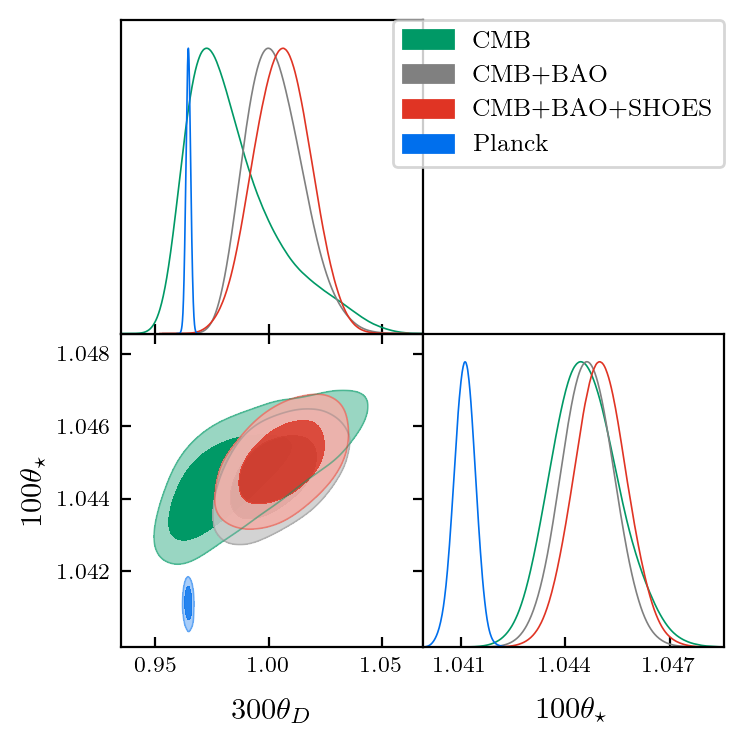

In [56]:
g = plots.get_subplot_plotter()
labels = ["CMB", "CMB+BAO", "CMB+BAO+SHOES", "Planck"]
g.triangle_plot([chains["modrec_new_lensing"], chains["modrec_new_lensing_bao"],chains["modrec_new_lensing_bao_shoes"], chains["planck_baseline"]], params=['theta_D_300', "theta_star_100"], legend_labels=labels, filled=True)


In [18]:
#chains["planck_baseline"].addDerived(2*np.pi/chains["planck_baseline"].getParams().kd, name="r_D", label="r_D")
#chains["planck_baseline"].addDerived(2*np.pi/chains["planck_baseline"].getParams().kd, name="r_D", label="r_D")

#    chains[chain_name].saveChainsAsText(os.path.join("/Users/gabe/projects/recombination/data/chains/{}/chains/{}".format(chain_name, chain_name)), make_dirs=False, properties=None)

In [26]:
par_index = lambda p: list(chains["planck_baseline"].getParams().__dict__.keys()).index(p)

np.mean(100* chains["planck_baseline"].getParams().rstar/ (chains["planck_baseline"].getParams().DAstar*1000))

1.0410993340491905

In [36]:
chains["planck_baseline"].getParams().__dict__.keys()


dict_keys(['omegabh2', 'omegach2', 'theta', 'tau', 'logA', 'ns', 'calPlanck', 'acib217', 'xi', 'asz143', 'aps100', 'aps143', 'aps143217', 'aps217', 'aksz', 'kgal100', 'kgal143', 'kgal143217', 'kgal217', 'galfTE100', 'galfTE100143', 'galfTE100217', 'galfTE143', 'galfTE143217', 'galfTE217', 'cal0', 'cal2', 'H0', 'omegal', 'omegam', 'omegamh2', 'omegamh3', 'sigma8', 'S8', 's8omegamp5', 's8omegamp25', 's8h5', 'rdragh', 'rmsdeflect', 'zrei', 'A', 'clamp', 'DL40', 'DL220', 'DL810', 'DL1420', 'DL2000', 'ns02', 'yheused', 'YpBBN', 'DHBBN', 'age', 'zstar', 'rstar', 'thetastar', 'DAstar', 'zdrag', 'rdrag', 'kd', 'thetad', 'zeq', 'keq', 'thetaeq', 'thetarseq', 'Hubble015', 'DM015', 'Hubble038', 'DM038', 'Hubble051', 'DM051', 'Hubble061', 'DM061', 'Hubble233', 'DM233', 'fsigma8z015', 'sigma8z015', 'fsigma8z038', 'sigma8z038', 'fsigma8z051', 'sigma8z051', 'fsigma8z061', 'sigma8z061', 'fsigma8z233', 'sigma8z233', 'f2000_143', 'f2000_x', 'f2000_217', 'chi2_lensing', 'chi2_simall', 'chi2_lowl', 'chi2_

In [28]:
cosmo.comoving_distance(chains["planck_baseline"].mean(par_index("zstar")))

1.4278840194704443e+18

In [29]:
da_star_lcdm = get_emulator_quantity_from_chain(em, chains["lcdm_prec_lensing"], "da_star")

In [35]:
100*get_emulator_quantity_from_chain(em, chains["lcdm_prec_lensing"], "rs_star")/(da_star_lcdm*(1+get_emulator_quantity_from_chain(em, chains["lcdm_prec_lensing"], "z_star")))

array([1.04404906, 1.04404906, 1.04427784, ..., 1.04448409, 1.04443829,
       1.04445452])

In [45]:
total_predictions, total_models = get_predictions_for_selection(chains["planck_baseline"], em, criteria='none')
planck_k_D = damping(total_models, em)

In [43]:
planck_k_D

array([0.12278052, 0.12271181, 0.12265679, ..., 0.12381154, 0.12384823,
       0.12386105])

In [55]:
chains["planck_baseline"].addDerived(600*chains["planck_baseline"].getParams().__dict__["thetad"]/100, name="theta_D_300", label="300 \\theta_D")


In [53]:
600*chains["planck_baseline"].getParams().__dict__["thetad"]/100

array([0.965787 , 0.9660528, 0.966219 , ..., 0.961959 , 0.9619152,
       0.9618996])